In [ ]:
# Install Hadoop
!pip install pyspark


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=206b692b69002443ede528e3f0a17ebeda34938cc064ba32442d6bb7c3a82b8b
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark


In [ ]:
# Import SparkSession
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

In [ ]:
#Create and configure SparkSession and sparkContext:
spark = SparkSession.builder\
    .master("local[*]")\
    .appName("ML Term Deposit Pred")\
    .getOrCreate()
sc = spark.sparkContext

In [ ]:
# Check spark session information. Start spark
spark

In [ ]:
#Mount (connect to) Google drive to be able to read from it (copy data files into HDFS)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load train dataset
#for the Machine Learning example, please run the following code:
traindf = spark.read.csv('/content/drive/My\ Drive/train.csv', header = True, inferSchema = True)
traindf.printSchema()


root
 |-- EmployeeID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- Over18: string (nullable = true)
 |-- OverTime: string (nul

In [ ]:
#Now, we can print the first 5 observations to see that now have features column and label column:
import pandas as pd
pd.DataFrame(traindf.take(5), columns = traindf.columns)


EmployeeID  Age Attrition     BusinessTravel  DailyRate  Department  \
0     1313919   41        No      Travel_Rarely       1102  Cardiology   
1     1272912   33        No  Travel_Frequently       1392   Maternity   
2     1329390   59        No      Travel_Rarely       1324   Maternity   
3     1469740   38        No  Travel_Frequently        216   Maternity   
4     1101291   36        No      Travel_Rarely       1299   Maternity   

   DistanceFromHome  Education EducationField  EmployeeCount  ...  \
0                 1          2  Life Sciences              1  ...   
1                 3          4  Life Sciences              1  ...   
2                 3          3        Medical              1  ...   
3                23          3  Life Sciences              1  ...   
4                27          3        Medical              1  ...   

   RelationshipSatisfaction StandardHours  Shift  TotalWorkingYears  \
0                         1            80      0                  8   
1                         3            80      0                  8   
2                         1            80      3                 12   
3                         2            80      0                 10   
4                         2            80      2                 17   

   TrainingTimesLastYear WorkLifeBalance  YearsAtCompany YearsInCurrentRole  \
0                      0               1               6                  4   
1                      3               3               8                  7   
2                      3               2               1                  0   
3                      2               3               9                  7   
4                      3               2               7                  7   

   YearsSinceLastPromotion  YearsWithCurrManager  
0                        0                     5  
1                        3                     0  
2                        0                     0  
3                        1                     8  
4                        7                     7  

[5 rows x 35 columns]

In [ ]:
#Count total number of rows
print("Total number of rows: " + str(traindf.count()))


Total number of rows: 2048


In [ ]:
#Also, we can check the frequency of the classes (yes/no) in the deposit variable. We will group the classes we have in the dataset and then, count the occurrences of each class. Finally, we will convert the result to Python’s Panadas to print out the result as Pandas dataframe:
#This also checks if the data is balanced
traindf.groupby('Attrition').count().toPandas()

Attrition  count
0        No   1029
1       Yes   1019

In [ ]:
#Next, we can calculate summary statics for the numeric variables in the dataset:

# you can manually select the numeric variables (only run one of these)
numeric_features = ['YearsAtCompany', 'NumCompaniesWorked', 'TrainingTimesLastYear', 'MonthlyRate', 'PercentSalaryHike', 'TotalWorkingYears', 'DistanceFromHome', 'DailyRate', 'HourlyRate']


In [ ]:
# Using the describe function to calculate the summary statistics of the numeric variables
traindf.select(numeric_features).describe().toPandas()


summary     YearsAtCompany  NumCompaniesWorked TrainingTimesLastYear  \
0   count               2048                2048                  2048   
1    mean      5.51123046875        2.6904296875          2.7490234375   
2  stddev  5.448239439878229  2.5731821640484633    1.3373368980674178   
3     min                  0                   0                     0   
4     max                 37                   9                     6   

         MonthlyRate   PercentSalaryHike  TotalWorkingYears  \
0               2048                2048               2048   
1  14422.71728515625      15.20654296875      9.18310546875   
2  6978.406978995178  3.6665903599554186  7.444054011861999   
3               2097                  11                  0   
4              26999                  25                 40   

    DistanceFromHome          DailyRate          HourlyRate  
0               2048               2048                2048  
1       10.462890625        780.6015625      64.35009765625  
2  8.608716787799175  403.2665344884197  19.888501856523963  
3                  1                102                  30  
4                 29               1499                 100

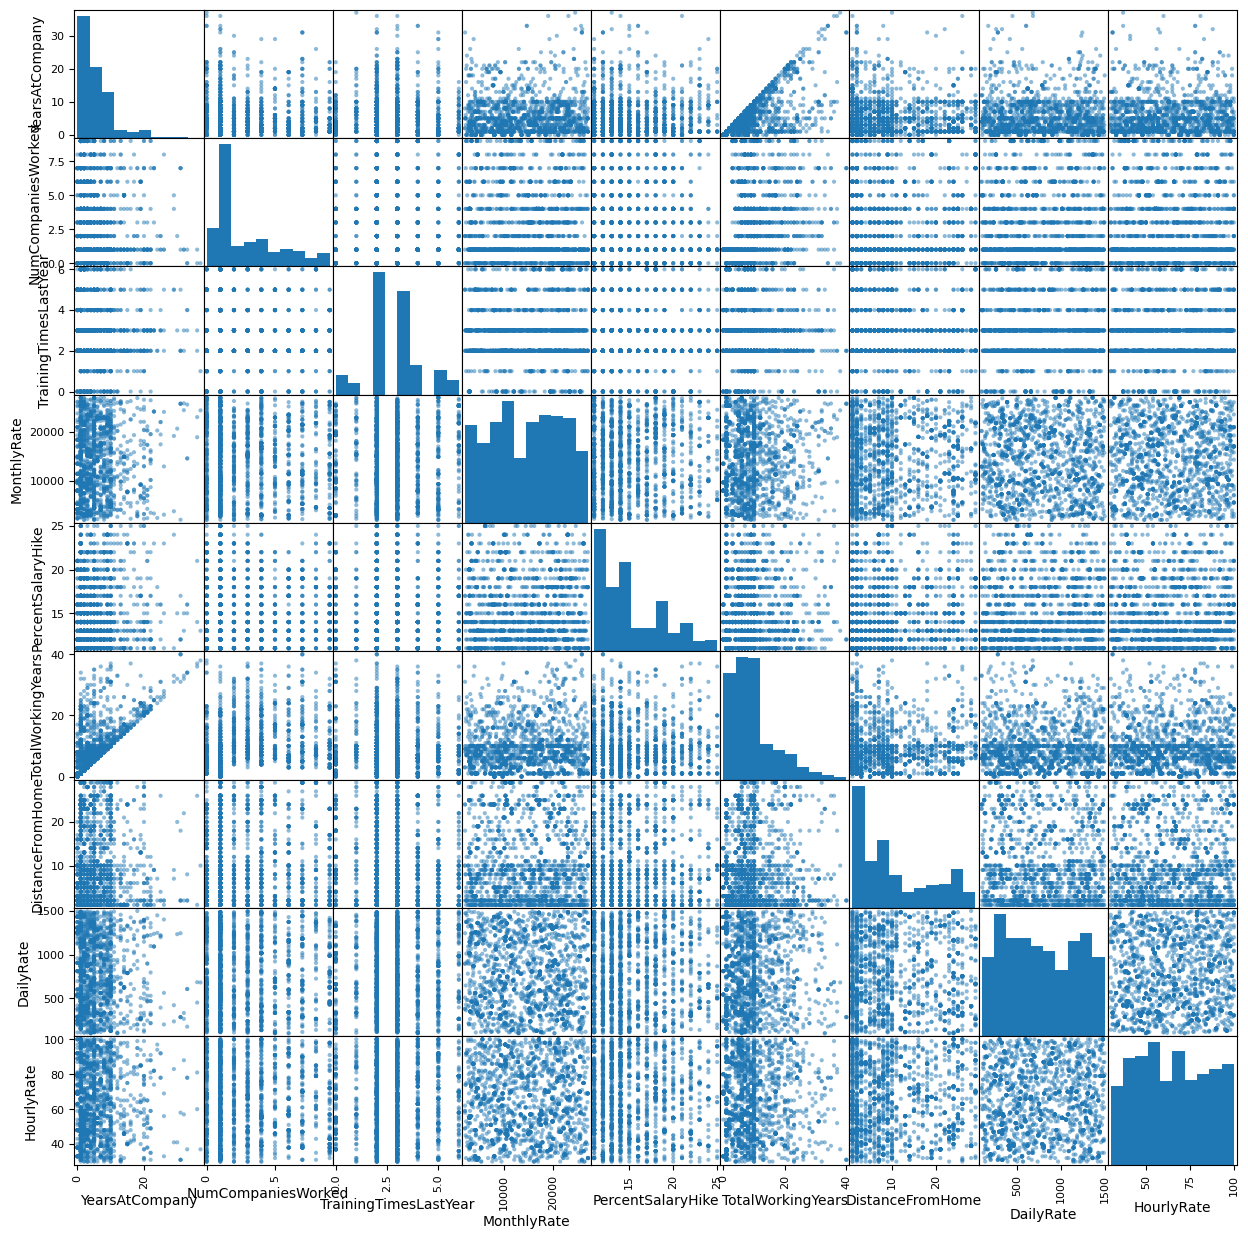

In [ ]:
# Also, we can calculate and plot the correlations between the numeric variables:

# import the scatter_matrix function
from pandas.plotting import scatter_matrix
# converting the numeric features to Panadas dataframe and assigning them to variable
# numeric_data
numeric_data = traindf.select(numeric_features).toPandas()
# using scatter_matrix function to visualize the correlations between the numeric variables
axs = scatter_matrix(numeric_data, figsize = (15, 15))

Text(0.5, 1.0, 'Correlation Heatmap')

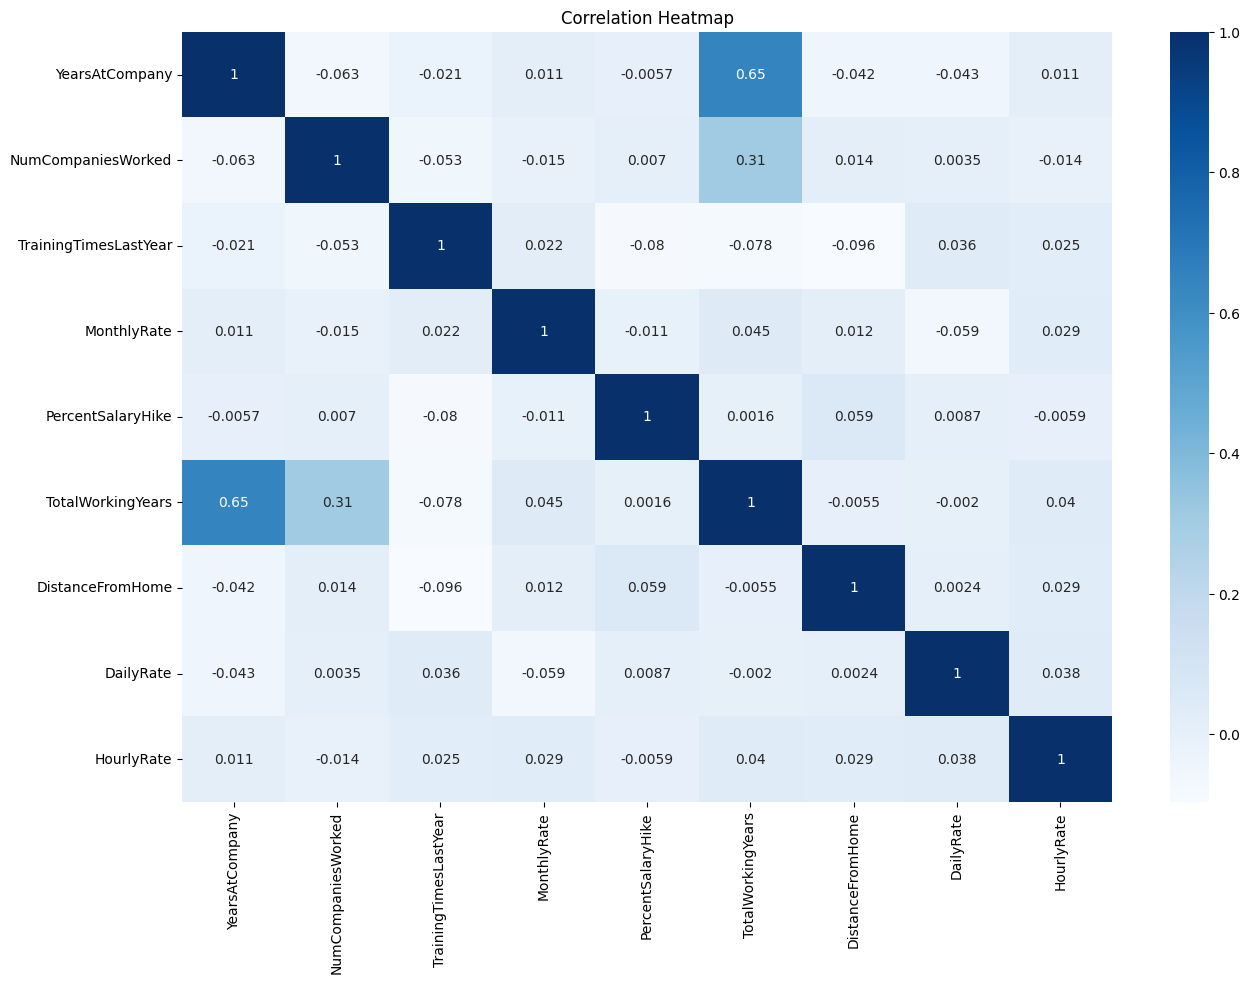

In [ ]:
#We can see that there aren’t highly correlated numeric variables. Also, we can also use heatmap as another way of investigating the correlation between the numeric variables. For this, we will use seaborn package to generate the heatmap visualization:

import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15,10))
sns.heatmap(numeric_data.corr(method = 'pearson'), annot = True, cmap = "Blues")
plt.title("Correlation Heatmap")

In [ ]:
# My personal note --- MAY USE DDA COURSEWORK FROM HERE?????

# select all the variables from the dataframe except day and month
traindf = traindf.select('YearsAtCompany', 'NumCompaniesWorked', 'TrainingTimesLastYear', 'MonthlyRate', 'PercentSalaryHike', 'TotalWorkingYears', 'DistanceFromHome', 'DailyRate', 'HourlyRate', 'BusinessTravel', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobRole', 'MaritalStatus', 'OverTime', 'Shift', 'WorkLifeBalance', 'Attrition')

cols = traindf.columns 

In [ ]:
# print the dataframe again after selecting the variables
traindf.printSchema()

root
 |-- YearsAtCompany: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- TrainingTimesLastYear: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- PercentSalaryHike: integer (nullable = true)
 |-- TotalWorkingYears: integer (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- OverTime: string (nullable = true)
 |-- Shift: integer (nullable = true)
 |-- WorkLifeBalance: integer (nullable = true)
 |-- Attrition: string (nullable = true)



In [ ]:
# import the required functions
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

# select the categorical columns
categoricalColumns = ['BusinessTravel', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobRole', 'MaritalStatus', 'OverTime', 'Shift', 'WorkLifeBalance']

# create empty list called stages that will be used to contain the results of StringIndexer and 
#  OneHotEncoder
stages = []

# for loop to index each categorical column using the StringIndexer function. Then, the 
# OneHotEncoder function is used to convert indexed categorical variables into one-hot
# encoded variables
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages = stages + [stringIndexer, encoder]

# we use the StringIndexer again to encode our labels to label indices
label_stringIdx = StringIndexer(inputCol = 'Attrition', outputCol = 'label')
stages = stages + [label_stringIdx]

# we use the VectorAssembler to combine all the feature columns into a single vector column.
numericCols = ['YearsAtCompany', 'NumCompaniesWorked', 'TrainingTimesLastYear', 'MonthlyRate', 'PercentSalaryHike', 'TotalWorkingYears', 'DistanceFromHome', 'DailyRate', 'HourlyRate']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol = "features")
stages = stages + [assembler]

In [ ]:
# HERE WE CREATE THE MACHINE LEARNING PIPELINE

# import Pipeline
from pyspark.ml import Pipeline

# steps to create the ML pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(traindf)
traindf = pipelineModel.transform(traindf)
selectedCols = ['label', 'features'] + cols
traindf = traindf.select(selectedCols)
traindf.printSchema()


root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- YearsAtCompany: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- TrainingTimesLastYear: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- PercentSalaryHike: integer (nullable = true)
 |-- TotalWorkingYears: integer (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- OverTime: string (nullable = true)
 |-- Shift: integer (nullable = true)
 |-- WorkLifeBalance: integer (nullable = true)
 |-- Attrition: string (nullable = true)



In [ ]:
#Now, we can print the first 5 observations to see that now have features column and label column:
# The label in encoded into 1 and 0. ALl featuures combined are encoded in 1 column, with target variable in another column called labael. 
pd.DataFrame(traindf.take(5), columns = traindf.columns)

label                                           features  YearsAtCompany  \
0    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...               6   
1    0.0  (0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...               8   
2    0.0  (1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...               1   
3    0.0  (0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...               9   
4    0.0  (1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...               7   

   NumCompaniesWorked  TrainingTimesLastYear  MonthlyRate  PercentSalaryHike  \
0                   8                      0        19479                 11   
1                   1                      3        23159                 11   
2                   4                      3         9964                 20   
3                   0                      2         8787                 21   
4                   6                      3        16577                 13   

   TotalWorkingYears  DistanceFromHome  DailyRate  ...     BusinessTravel  \
0                  8                 1       1102  ...      Travel_Rarely   
1                  8                 3       1392  ...  Travel_Frequently   
2                 12                 3       1324  ...      Travel_Rarely   
3                 10                23        216  ...  Travel_Frequently   
4                 17                27       1299  ...      Travel_Rarely   

  EnvironmentSatisfaction  JobInvolvement  JobLevel    JobRole MaritalStatus  \
0                       2               3         2      Nurse        Single   
1                       4               3         1      Other       Married   
2                       3               4         1      Nurse       Married   
3                       4               2         3  Therapist        Single   
4                       3               3         2      Nurse       Married   

  OverTime Shift  WorkLifeBalance  Attrition  
0      Yes     0                1         No  
1      Yes     0                3         No  
2      Yes     3                2         No  
3       No     0                3         No  
4       No     2                2         No  

[5 rows x 21 columns]

In [ ]:
#Load test dataset
#for the Machine Learning example, please run the following code:
testdf = spark.read.csv('/content/drive/My\ Drive/test.csv', header = True, inferSchema = True)
testdf.printSchema()

root
 |-- EmployeeID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- Over18: string (nullable = true)
 |-- OverTime: string (nul

In [ ]:
#Now, we can print the first 5 observations to see that now have features column and label column:
import pandas as pd
pd.DataFrame(testdf.take(5), columns = testdf.columns)

EmployeeID  Age Attrition     BusinessTravel  DailyRate  Department  \
0     1200302   49        No  Travel_Frequently        279   Maternity   
1     1699288   30        No      Travel_Rarely       1358   Maternity   
2     1402945   36        No      Travel_Rarely       1218  Cardiology   
3     1801346   34        No      Travel_Rarely        699   Maternity   
4     1650304   43        No      Travel_Rarely       1273   Maternity   

   DistanceFromHome  Education EducationField  EmployeeCount  ...  \
0                 8          1  Life Sciences              1  ...   
1                24          1  Life Sciences              1  ...   
2                 9          4  Life Sciences              1  ...   
3                 6          1        Medical              1  ...   
4                 2          2        Medical              1  ...   

   RelationshipSatisfaction StandardHours  Shift  TotalWorkingYears  \
0                         4            80      1                 10   
1                         2            80      1                  1   
2                         2            80      0                 10   
3                         3            80      0                  8   
4                         4            80      2                  6   

   TrainingTimesLastYear WorkLifeBalance  YearsAtCompany YearsInCurrentRole  \
0                      3               3              10                  7   
1                      2               3               1                  0   
2                      4               3               5                  3   
3                      2               3               4                  2   
4                      3               2               5                  3   

   YearsSinceLastPromotion  YearsWithCurrManager  
0                        1                     7  
1                        0                     0  
2                        0                     3  
3                        1                     3  
4                        1                     4  

[5 rows x 35 columns]

In [ ]:
#Count total number of rows
print("Total number of rows: " + str(testdf.count()))

Total number of rows: 252


In [ ]:
#Also, we can check the frequency of the classes (yes/no) in the deposit variable. We will group the classes we have in the dataset and then, count the occurrences of each class. Finally, we will convert the result to Python’s Panadas to print out the result as Pandas dataframe:
#This also checks if the data is balanced
testdf.groupby('Attrition').count().toPandas()

Attrition  count
0        No    225
1       Yes     27

In [ ]:
#Next, we can calculate summary statics for the numeric variables in the dataset:

# you can manually select the numeric variables (only run one of these)
numeric_features = ['YearsAtCompany', 'NumCompaniesWorked', 'TrainingTimesLastYear', 'MonthlyRate', 'PercentSalaryHike', 'TotalWorkingYears', 'DistanceFromHome', 'DailyRate', 'HourlyRate']


In [ ]:
# Using the describe function to calculate the summary statistics of the numeric variables
testdf.select(numeric_features).describe().toPandas()


summary     YearsAtCompany  NumCompaniesWorked TrainingTimesLastYear  \
0   count                252                 252                   252   
1    mean   6.98015873015873  2.5476190476190474     2.742063492063492   
2  stddev  5.980346561414702  2.3434477371019335    1.3122683851551855   
3     min                  0                   0                     0   
4     max                 33                   9                     6   

          MonthlyRate  PercentSalaryHike   TotalWorkingYears  \
0                 252                252                 252   
1  13717.309523809523  15.11111111111111  11.468253968253968   
2   7257.554206424626  3.728264439739361   8.296964844115353   
3                2122                 11                   0   
4               26956                 25                  37   

    DistanceFromHome          DailyRate          HourlyRate  
0                252                252                 252  
1  9.301587301587302  829.4325396825396   65.35714285714286  
2   8.48271722352809   384.075139214254  20.365177797029183  
3                  1                117                  30  
4                 29               1498                 100

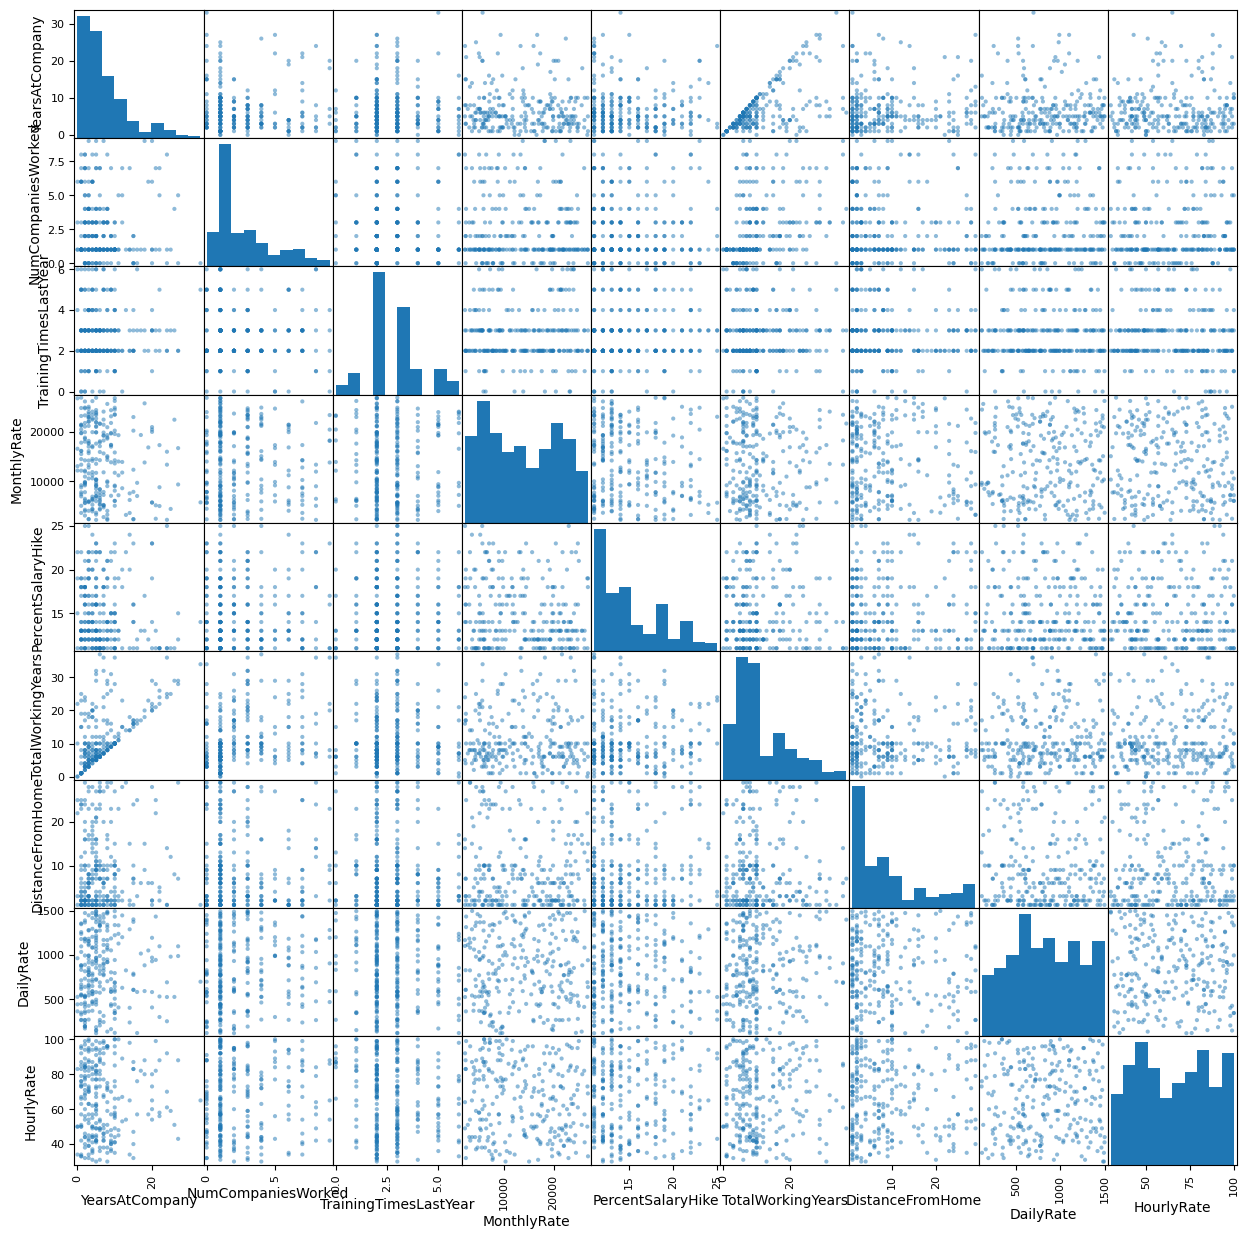

In [ ]:
# Also, we can calculate and plot the correlations between the numeric variables:

# import the scatter_matrix function
from pandas.plotting import scatter_matrix
# converting the numeric features to Panadas dataframe and assigning them to variable
# numeric_data
numeric_data = testdf.select(numeric_features).toPandas()
# using scatter_matrix function to visualize the correlations between the numeric variables
axs = scatter_matrix(numeric_data, figsize = (15, 15))

Text(0.5, 1.0, 'Correlation Heatmap')

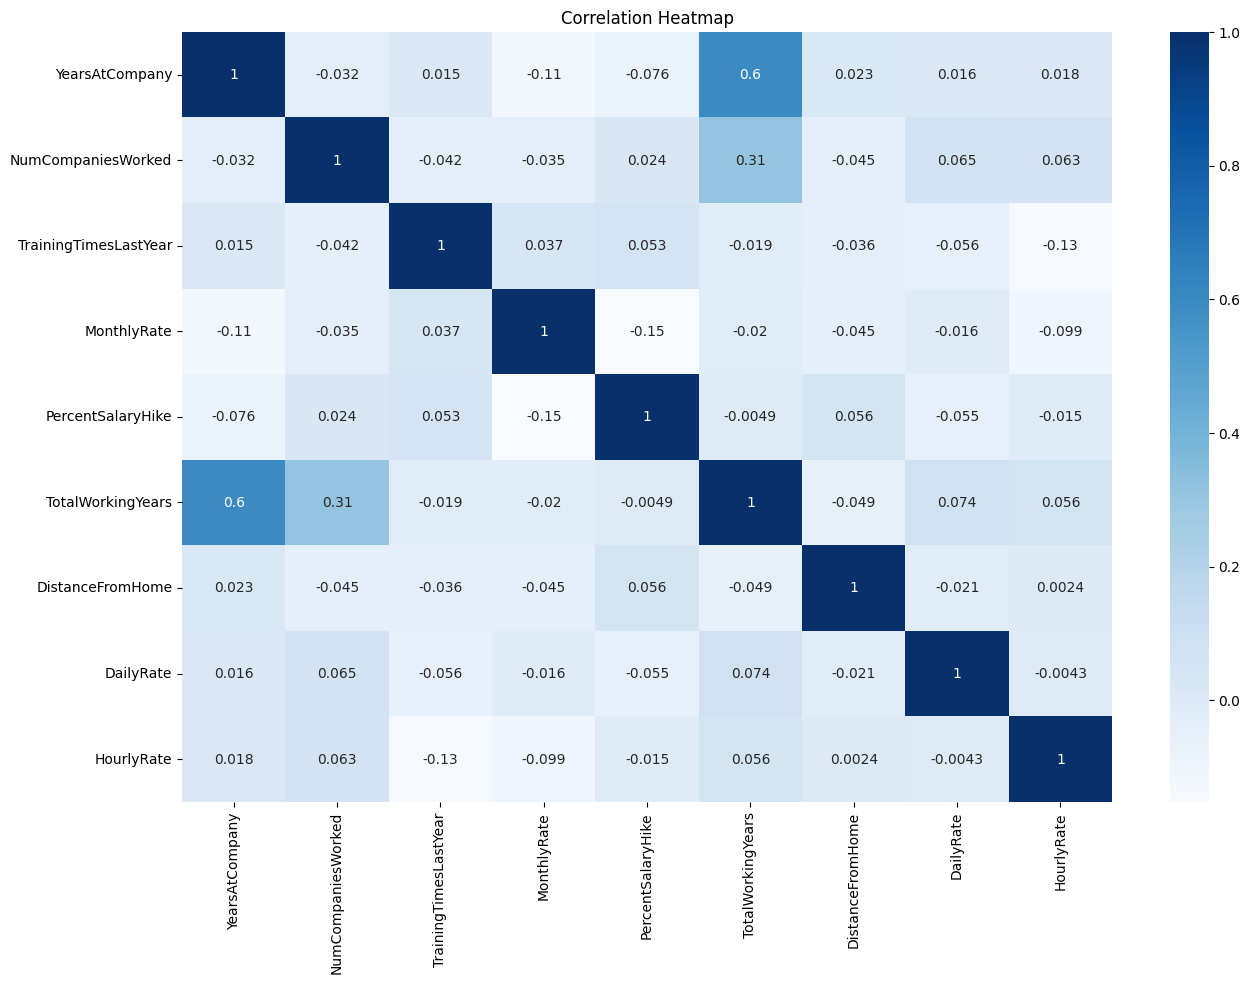

In [ ]:
#We can see that there aren’t highly correlated numeric variables. Also, we can also use heatmap as another way of investigating the correlation between the numeric variables. For this, we will use seaborn package to generate the heatmap visualization:

import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15,10))
sns.heatmap(numeric_data.corr(method = 'pearson'), annot = True, cmap = "Blues")
plt.title("Correlation Heatmap")

In [ ]:
# My personal note --- MAY USE DDA COURSEWORK FROM HERE?????

# select all the variables from the dataframe except day and month
testdf = testdf.select('YearsAtCompany', 'NumCompaniesWorked', 'TrainingTimesLastYear', 'MonthlyRate', 'PercentSalaryHike', 'TotalWorkingYears', 'DistanceFromHome', 'DailyRate', 'HourlyRate', 'BusinessTravel', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobRole', 'MaritalStatus', 'OverTime', 'Shift', 'WorkLifeBalance', 'Attrition')

cols = testdf.columns 

In [ ]:
# print the dataframe again after selecting the variables
testdf.printSchema()

root
 |-- YearsAtCompany: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- TrainingTimesLastYear: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- PercentSalaryHike: integer (nullable = true)
 |-- TotalWorkingYears: integer (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- OverTime: string (nullable = true)
 |-- Shift: integer (nullable = true)
 |-- WorkLifeBalance: integer (nullable = true)
 |-- Attrition: string (nullable = true)



In [ ]:
# import the required functions
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

# select the categorical columns
categoricalColumns = ['BusinessTravel', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobRole', 'MaritalStatus', 'OverTime', 'Shift', 'WorkLifeBalance']

# create empty list called stages that will be used to contain the results of StringIndexer and 
#  OneHotEncoder
stages = []

# for loop to index each categorical column using the StringIndexer function. Then, the 
# OneHotEncoder function is used to convert indexed categorical variables into one-hot
# encoded variables
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages = stages + [stringIndexer, encoder]

# we use the StringIndexer again to encode our labels to label indices
label_stringIdx = StringIndexer(inputCol = 'Attrition', outputCol = 'label')
stages = stages + [label_stringIdx]

# we use the VectorAssembler to combine all the feature columns into a single vector column.
numericCols = ['YearsAtCompany', 'NumCompaniesWorked', 'TrainingTimesLastYear', 'MonthlyRate', 'PercentSalaryHike', 'TotalWorkingYears', 'DistanceFromHome', 'DailyRate', 'HourlyRate']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol = "features")
stages = stages + [assembler]

In [ ]:
# HERE WE CRAETE THE MACHINE LEARNING PIPELINE

# import Pipeline
from pyspark.ml import Pipeline

# steps to create the ML pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(testdf)
testdf = pipelineModel.transform(testdf)
selectedCols = ['label', 'features'] + cols
testdf = testdf.select(selectedCols)
testdf.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- YearsAtCompany: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- TrainingTimesLastYear: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- PercentSalaryHike: integer (nullable = true)
 |-- TotalWorkingYears: integer (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- OverTime: string (nullable = true)
 |-- Shift: integer (nullable = true)
 |-- WorkLifeBalance: integer (nullable = true)
 |-- Attrition: string (nullable = true)



In [ ]:
#Now, we can print the first 5 observations to see that now have features column and label column:
# The label in encoded into 1 and 0. ALl featuures combined are encoded in 1 column, with target variable in another column called labael. 
pd.DataFrame(testdf.take(5), columns = testdf.columns)

label                                           features  YearsAtCompany  \
0    0.0  (0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...              10   
1    0.0  (1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...               1   
2    0.0  (1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...               5   
3    0.0  (1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...               4   
4    0.0  (1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...               5   

   NumCompaniesWorked  TrainingTimesLastYear  MonthlyRate  PercentSalaryHike  \
0                   1                      3        24907                 23   
1                   1                      2        13335                 22   
2                   7                      4         6986                 23   
3                   2                      2        17102                 11   
4                   1                      3        21923                 12   

   TotalWorkingYears  DistanceFromHome  DailyRate  ...     BusinessTravel  \
0                 10                 8        279  ...  Travel_Frequently   
1                  1                24       1358  ...      Travel_Rarely   
2                 10                 9       1218  ...      Travel_Rarely   
3                  8                 6        699  ...      Travel_Rarely   
4                  6                 2       1273  ...      Travel_Rarely   

  EnvironmentSatisfaction  JobInvolvement  JobLevel  JobRole MaritalStatus  \
0                       3               2         2    Other       Married   
1                       4               3         1    Nurse      Divorced   
2                       3               2         1    Other        Single   
3                       2               3         1    Other        Single   
4                       4               4         1    Other      Divorced   

  OverTime Shift  WorkLifeBalance  Attrition  
0       No     1                3         No  
1       No     1                3         No  
2       No     0                3         No  
3       No     0                3         No  
4       No     2                2         No  

[5 rows x 21 columns]

In [ ]:
#Load validation dataset
#for the Machine Learning example, please run the following code:
validdf = spark.read.csv('/content/drive/My\ Drive/valid.csv', header = True, inferSchema = True)
validdf.printSchema()

root
 |-- EmployeeID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- Over18: string (nullable = true)
 |-- OverTime: string (nul

In [ ]:
#Now, we can print the first 5 observations to see that now have features column and label column:
import pandas as pd
pd.DataFrame(validdf.take(5), columns = validdf.columns)

EmployeeID  Age Attrition     BusinessTravel  DailyRate Department  \
0     1414939   27        No      Travel_Rarely        591  Maternity   
1     1633361   32        No  Travel_Frequently       1005  Maternity   
2     1196281   29        No      Travel_Rarely        153  Maternity   
3     1207951   31        No      Travel_Rarely        670  Maternity   
4     1880078   21        No      Travel_Rarely        391  Maternity   

   DistanceFromHome  Education EducationField  EmployeeCount  ...  \
0                 2          1        Medical              1  ...   
1                 2          2  Life Sciences              1  ...   
2                15          2  Life Sciences              1  ...   
3                26          1  Life Sciences              1  ...   
4                15          2  Life Sciences              1  ...   

   RelationshipSatisfaction StandardHours  Shift  TotalWorkingYears  \
0                         4            80      1                  6   
1                         3            80      0                  8   
2                         4            80      0                 10   
3                         4            80      1                  5   
4                         4            80      0                  0   

   TrainingTimesLastYear WorkLifeBalance  YearsAtCompany YearsInCurrentRole  \
0                      3               3               2                  2   
1                      2               2               7                  7   
2                      3               3               9                  5   
3                      1               2               5                  2   
4                      6               3               0                  0   

   YearsSinceLastPromotion  YearsWithCurrManager  
0                        2                     2  
1                        3                     6  
2                        0                     8  
3                        4                     3  
4                        0                     0  

[5 rows x 35 columns]

In [ ]:
#Count total number of rows
print("Total number of rows: " + str(validdf.count()))

Total number of rows: 250


In [ ]:
#Also, we can check the frequency of the classes (yes/no) in the deposit variable. We will group the classes we have in the dataset and then, count the occurrences of each class. Finally, we will convert the result to Python’s Panadas to print out the result as Pandas dataframe:
#This also checks if the data is balanced
validdf.groupby('Attrition').count().toPandas()

Attrition  count
0        No    223
1       Yes     27

In [ ]:
#Next, we can calculate summary statics for the numeric variables in the dataset:

# you can manually select the numeric variables (only run one of these)
numeric_features = ['YearsAtCompany', 'NumCompaniesWorked', 'TrainingTimesLastYear', 'MonthlyRate', 'PercentSalaryHike', 'TotalWorkingYears', 'DistanceFromHome', 'DailyRate', 'HourlyRate']


In [ ]:
# Using the describe function to calculate the summary statistics of the numeric variables
validdf.select(numeric_features).describe().toPandas()


summary     YearsAtCompany NumCompaniesWorked TrainingTimesLastYear  \
0   count                250                250                   250   
1    mean              7.308              2.664                 2.832   
2  stddev  6.687903123757932  2.399611749051237    1.1939337970116208   
3     min                  0                  0                     0   
4     max                 40                  9                     6   

         MonthlyRate   PercentSalaryHike  TotalWorkingYears  \
0                250                 250                250   
1           14323.18              15.128             11.432   
2  7345.288661563052  3.6700809222554778  7.868738410743291   
3               2094                  11                  0   
4              26959                  25                 40   

    DistanceFromHome          DailyRate         HourlyRate  
0                250                250                250  
1              8.672            783.156             65.344  
2  7.963547472917685  396.3350014792919  19.78158000844528  
3                  1                104                 30  
4                 29               1495                100

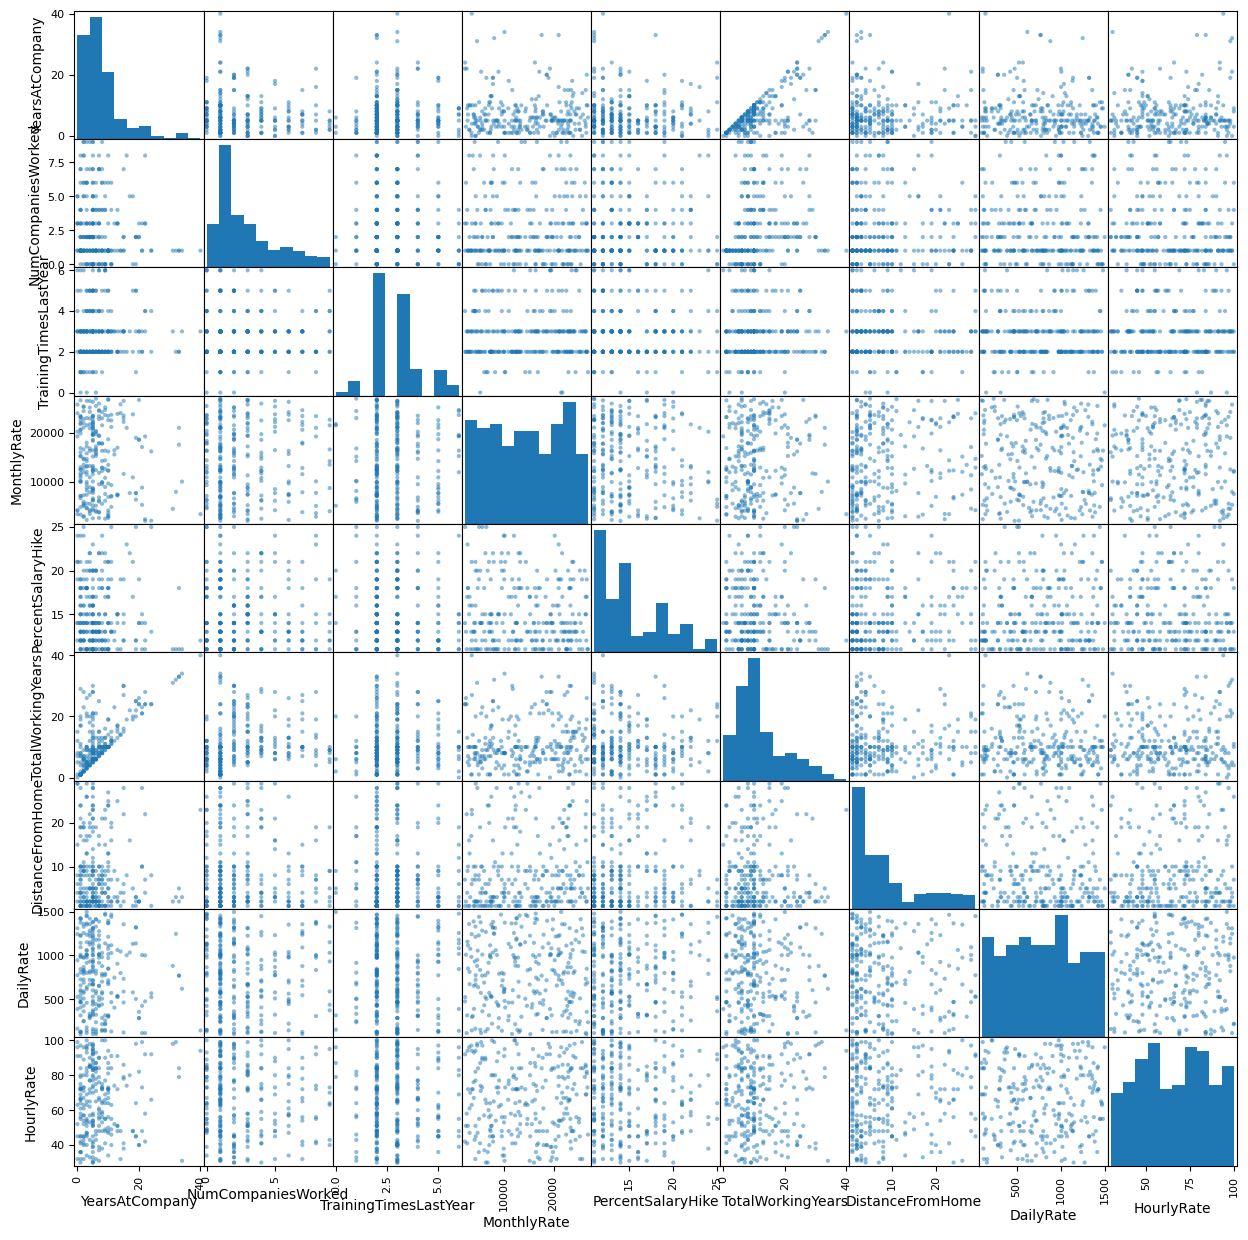

In [ ]:
# Also, we can calculate and plot the correlations between the numeric variables:

# import the scatter_matrix function
from pandas.plotting import scatter_matrix
# converting the numeric features to Panadas dataframe and assigning them to variable
# numeric_data
numeric_data = validdf.select(numeric_features).toPandas()
# using scatter_matrix function to visualize the correlations between the numeric variables
axs = scatter_matrix(numeric_data, figsize = (15, 15))

Text(0.5, 1.0, 'Correlation Heatmap')

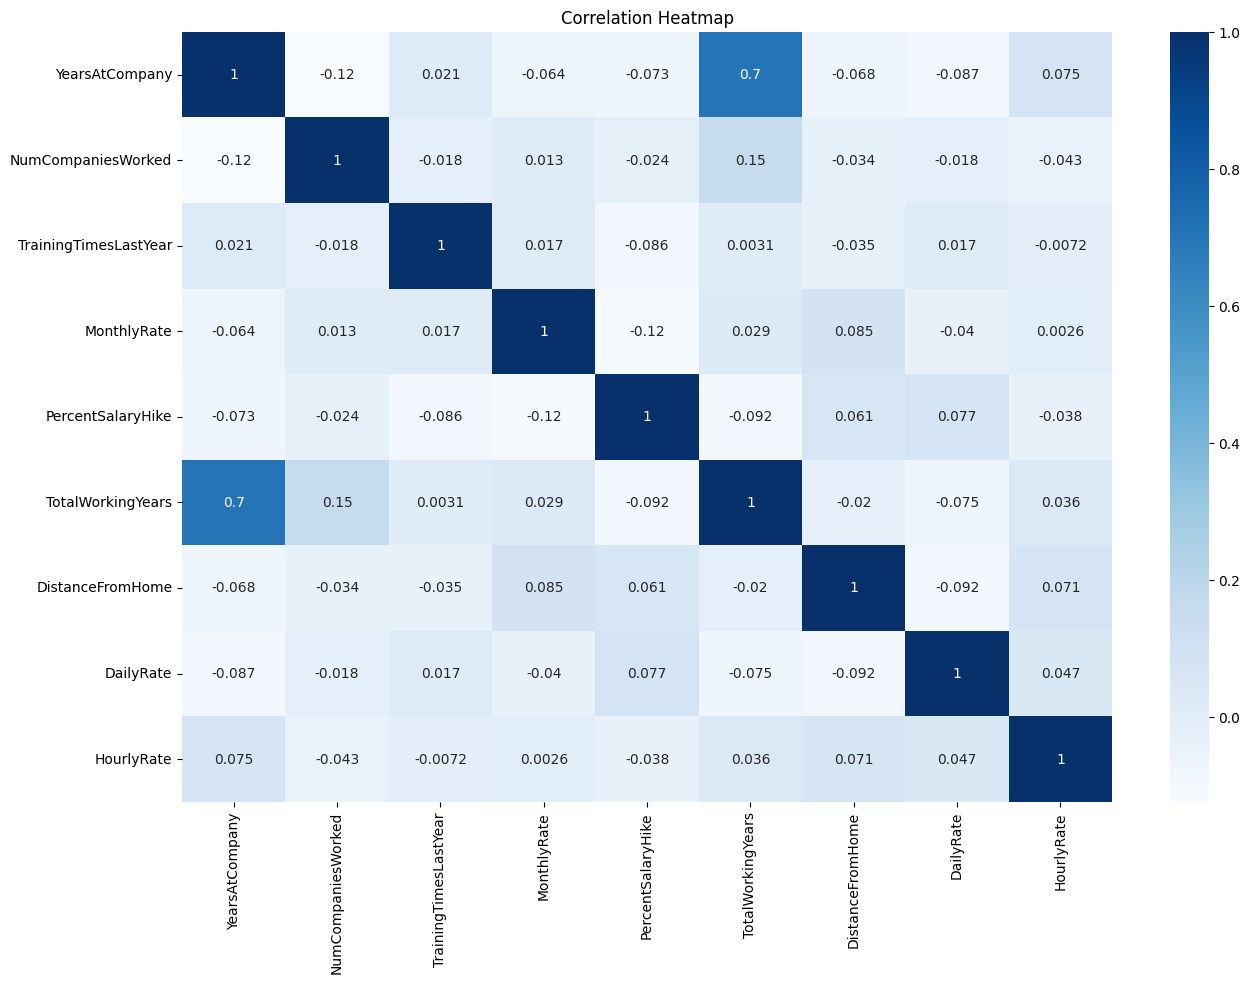

In [ ]:
#We can see that there aren’t highly correlated numeric variables. Also, we can also use heatmap as another way of investigating the correlation between the numeric variables. For this, we will use seaborn package to generate the heatmap visualization:

import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15,10))
sns.heatmap(numeric_data.corr(method = 'pearson'), annot = True, cmap = "Blues")
plt.title("Correlation Heatmap")

In [ ]:
# My personal note --- MAY USE DDA COURSEWORK FROM HERE?????

# select all the variables from the dataframe except day and month
validdf = validdf.select('YearsAtCompany', 'NumCompaniesWorked', 'TrainingTimesLastYear', 'MonthlyRate', 'PercentSalaryHike', 'TotalWorkingYears', 'DistanceFromHome', 'DailyRate', 'HourlyRate', 'BusinessTravel', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobRole', 'MaritalStatus', 'OverTime', 'Shift', 'WorkLifeBalance', 'Attrition')

cols = validdf.columns

In [ ]:
# print the dataframe again after selecting the variables
validdf.printSchema()

root
 |-- YearsAtCompany: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- TrainingTimesLastYear: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- PercentSalaryHike: integer (nullable = true)
 |-- TotalWorkingYears: integer (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- OverTime: string (nullable = true)
 |-- Shift: integer (nullable = true)
 |-- WorkLifeBalance: integer (nullable = true)
 |-- Attrition: string (nullable = true)



In [ ]:
# import the required functions
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

# select the categorical columns
categoricalColumns = ['BusinessTravel', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobRole', 'MaritalStatus', 'OverTime', 'Shift', 'WorkLifeBalance']

# create empty list called stages that will be used to contain the results of StringIndexer and 
#  OneHotEncoder
stages = []

# for loop to index each categorical column using the StringIndexer function. Then, the 
# OneHotEncoder function is used to convert indexed categorical variables into one-hot
# encoded variables
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages = stages + [stringIndexer, encoder]

# we use the StringIndexer again to encode our labels to label indices
label_stringIdx = StringIndexer(inputCol = 'Attrition', outputCol = 'label')
stages = stages + [label_stringIdx]

# we use the VectorAssembler to combine all the feature columns into a single vector column.
numericCols = ['YearsAtCompany', 'NumCompaniesWorked', 'TrainingTimesLastYear', 'MonthlyRate', 'PercentSalaryHike', 'TotalWorkingYears', 'DistanceFromHome', 'DailyRate', 'HourlyRate']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol = "features")
stages = stages + [assembler]

In [ ]:
# HERE WE CRAETE THE MACHINE LEARNING PIPELINE

# import Pipeline
from pyspark.ml import Pipeline

# steps to create the ML pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(validdf)
validdf = pipelineModel.transform(validdf)
selectedCols = ['label', 'features'] + cols
validdf = validdf.select(selectedCols)
validdf.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- YearsAtCompany: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- TrainingTimesLastYear: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- PercentSalaryHike: integer (nullable = true)
 |-- TotalWorkingYears: integer (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- OverTime: string (nullable = true)
 |-- Shift: integer (nullable = true)
 |-- WorkLifeBalance: integer (nullable = true)
 |-- Attrition: string (nullable = true)



In [ ]:
#Now, we can print the first 5 observations to see that now have features column and label column:
# The label in encoded into 1 and 0. ALl featuures combined are encoded in 1 column, with target variable in another column called labael. 
pd.DataFrame(validdf.take(5), columns = validdf.columns)

label                                           features  YearsAtCompany  \
0    0.0  (1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...               2   
1    0.0  (0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...               7   
2    0.0  (1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...               9   
3    0.0  (1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...               5   
4    0.0  (1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...               0   

   NumCompaniesWorked  TrainingTimesLastYear  MonthlyRate  PercentSalaryHike  \
0                   9                      3        16632                 12   
1                   0                      2        11864                 13   
2                   0                      3        12682                 12   
3                   1                      1        15170                 17   
4                   1                      6        19281                 14   

   TotalWorkingYears  DistanceFromHome  DailyRate  ...     BusinessTravel  \
0                  6                 2        591  ...      Travel_Rarely   
1                  8                 2       1005  ...  Travel_Frequently   
2                 10                15        153  ...      Travel_Rarely   
3                  5                26        670  ...      Travel_Rarely   
4                  0                15        391  ...      Travel_Rarely   

  EnvironmentSatisfaction  JobInvolvement  JobLevel  JobRole MaritalStatus  \
0                       1               3         1    Nurse       Married   
1                       4               3         1    Nurse        Single   
2                       4               2         2    Nurse        Single   
3                       1               3         1    Other      Divorced   
4                       3               3         1    Other        Single   

  OverTime Shift  WorkLifeBalance  Attrition  
0       No     1                3         No  
1       No     0                2         No  
2      Yes     0                3         No  
3       No     1                2         No  
4       No     0                3         No  

[5 rows x 21 columns]

In [ ]:
# Show of data split into training, validation and testing
print("Training Dataset Count: " + str(traindf.count()))
print("Validation Dataset Count: " + str(validdf.count()))
print("Test Dataset Count: " + str(testdf.count()))

Training Dataset Count: 2048
Validation Dataset Count: 250
Test Dataset Count: 252


In [ ]:
## DECISION TREE

# import the Decision Tree classifier
from pyspark.ml.classification import DecisionTreeClassifier

# configuring and training the Decision Tree classifier using the training data
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(traindf)

# Testing the performance of the Decision Tree classifier using the testing data
predictions = dtModel.transform(testdf)
predictions.select('label', 'prediction', 'rawPrediction', 'probability').show(10)


+-----+----------+-------------+--------------------+
|label|prediction|rawPrediction|         probability|
+-----+----------+-------------+--------------------+
|  0.0|       0.0|[771.0,179.0]|[0.81157894736842...|
|  0.0|       1.0| [28.0,144.0]|[0.16279069767441...|
|  0.0|       0.0|[771.0,179.0]|[0.81157894736842...|
|  0.0|       0.0|[771.0,179.0]|[0.81157894736842...|
|  0.0|       0.0|[771.0,179.0]|[0.81157894736842...|
|  0.0|       0.0|[771.0,179.0]|[0.81157894736842...|
|  0.0|       0.0|[771.0,179.0]|[0.81157894736842...|
|  0.0|       1.0| [28.0,144.0]|[0.16279069767441...|
|  0.0|       0.0|[771.0,179.0]|[0.81157894736842...|
|  0.0|       0.0| [129.0,67.0]|[0.65816326530612...|
+-----+----------+-------------+--------------------+
only showing top 10 rows



In [ ]:
# Import model evaluator only if not has been done before
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))


Test Area Under ROC 0.3424691358024691


In [ ]:
# compute TN, TP, FN, and FP
predictions.groupBy('label', 'prediction').count().show()

# Calculate the elements of the confusion matrix
TN = predictions.filter('prediction = 0 AND label = prediction').count()
TP = predictions.filter('prediction = 1 AND label = prediction').count()
FN = predictions.filter('prediction = 0 AND label <> prediction').count()
FP = predictions.filter('prediction = 1 AND label <> prediction').count()

# calculate accuracy, precision, recall, and F1-score
accuracy = (TN + TP) / (TN + TP + FN + FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F = 2 * (precision*recall) / (precision + recall)

print('n precision: %0.3f' % precision)
print('n recall: %0.3f' % recall)
print('n accuracy: %0.3f' % accuracy)
print('n F1 score: %0.3f' % F)


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|   15|
|  0.0|       1.0|   42|
|  1.0|       0.0|   12|
|  0.0|       0.0|  183|
+-----+----------+-----+

n precision: 0.263
n recall: 0.556
n accuracy: 0.786
n F1 score: 0.357


In [ ]:
#TO SEE HOW TO IMPROVE ANY MODEL
#Decision Tree result for accuracy is: 78.6%. 
#We will try tuning this model with ParamGridBuilder and the CrossValidator. Before that we can use explainParams() to print a list of all params and their definitions to understand what params available for tuning:

print(dt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features, current: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label, current: label)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins for discreti

In [ ]:
#Updating model parameters
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [2, 4, 6])
             .addGrid(dt.maxBins, [30, 40])
             .addGrid(dt.maxDepth, [5, 30])
             .build())

In [ ]:
# Will use the 'valid' dataset to improve performance of the Decision Tree classifier results.


cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations.  This can take about 6 minutes since it is training 1 trees with numerous branches!
cvModel = cv.fit(traindf)
predictions = cvModel.transform(validdf)
evaluator.evaluate(predictions)


0.5785583790068095

In [ ]:
#Now result above looks better. Will now re-run model tunning on 'test' dataset. 

# Model has now improved from 0.578 to 0.599

cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations.  This can take about 6 minutes since it is training 1 trees with numerous branches!
cvModel = cv.fit(traindf)
predictions = cvModel.transform(testdf)
evaluator.evaluate(predictions)

#NOTE
#I did this classification exercise in PySpark, as a way of distributted programming inorder as it is combining HPCI and Machine Learning at the same time.


0.5992592592592593